# Figure Four: PFSS Model

- Panel (a): Full Carrington EUV map with PFSS model overlaid
    - footpoints (grey, pink (FSW), green (SSW), purple (SASW))
    - trajectory (red (positive polarity), blue (negative polarity))
    - HCS (white)
    - footpoint radial magnetic field ($B_{r, \, 0}$)
- Bottom Panels: zoom in of top panel onto four periods of interest along with footpoint brightness
    - Panel (b): HCS crossing
    - Panel (c): FSW region
    - Panel (d): SSW & SASW regions

## Imports

In [1]:
import sys, os
import astropy.units as u

import datetime
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt


import sunpy
import astrospice
from astropy.coordinates import SkyCoord

# from tools.psp_funcs import ballistically_project

import astropy.units as u
import sunpy.coordinates as scoords
import tools.pfss_funcs as pfss_funcs
import tools.utilities as utils

for sc in ['psp','solar orbiter'] : kernels = astrospice.registry.get_kernels(sc,'predict') 

# COLORS
c = ['#ae017e','#085A99',  '#c98000'] # darker colors
lightc = ['#FCA4C4',  '#8FD3F4', '#FFCC70'] # lighter colors
fcol = 'mistyrose'
sacol='lavender'
sacol = 'violet'
f2col = 'lightgreen'
hcol = 'lightblue'
aa = 0.6
lw=2
clon = '#ae017e'
clat = '#085A99'
rcol = 'dimgrey'
cmaps = ['RdPu', 'cool', 'Wistia', 'spring']

# REGIONS
loc_hcs = [113, 116]
fsw2 = [125, 135]
sasw = [175, 185]
fsw = [70, 85]

# DIRECTORIES
IMG_DIR = './figures'
DF_DIR = './results'
PlotDir = '/Users/tamarervin/mplstyle/'

RES_DIR = 'results'

# PLOT STYLING
plot_style = os.path.join(PlotDir, 'figure_series.mplstyle')
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.cal'] = 'Helvetica Neue LT Pro'
plt.rcParams.update({'font.size': 18})
plt.style.use(plot_style)

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

/Users/tamarervin/miniconda3/envs/analysis/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

## Data

In [2]:
# ### READ IN DATA ###
parker, parkerdownt, parkerdownl, pss, orbiter, orbiterdownl, orbiterdownt, oss, his_orbiter, his_orbiterdownt, his_orbiterdownl = utils.read_data(RES_DIR, sigma_time=20)

### DEFINE REGIONS ###
lon_footpoints = parker.sslon
hhcs = np.logical_and(lon_footpoints >= loc_hcs[0], lon_footpoints <=loc_hcs[1])
slow = np.logical_and(lon_footpoints >=sasw[0], lon_footpoints <=sasw[1])
fast = np.logical_and(lon_footpoints >=fsw[0], lon_footpoints <=fsw[1])


/Users/tamarervin/publications/e11_ch/tools/utilities.py:180: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  pss = parker.resample(sigma_bin, closed='left', label='left', loffset=sigma_bin / 2).mean()
/Users/tamarervin/publications/e11_ch/tools/utilities.py:180: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pss = parker.resample(sigma_bin, closed='left', label='left', loffset=sigma_bin / 2).mean()
/Users/tamarervin/publications/e11_ch/tools/utilities.py:189: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")


## Run PFSS Model

In [ ]:
# download/read in magnetogram
rss=2.0
filename = 'adapt40311_03k012_202202240000_i00005600n1.fts.gz'
filepath = f"{filename}"
adapt_magnetogram = pfss_funcs.adapt2pfsspy(filepath, return_magnetogram=True)
gong_map = sunpy.map.Map(adapt_magnetogram.data/1e5, adapt_magnetogram.meta)

# run PFSS model
pfss_model = pfss_funcs.adapt2pfsspy(filepath,rss)

# trace PFSS lines
flines = pfss_funcs.pfss2flines(pfss_model)

In [ ]:
from astropy.coordinates import SkyCoord

@u.quantity_input
def ballistic_delta_long(r:u.R_sun,
               r_inner=2.0*u.R_sun,
               vsw=360.*u.km/u.s,
               omega_sun=14.713*u.deg/u.d,
               ):
    """ 
    Ballistic longitudinal shift of a Parker spiral connecting two
    points at radius r and r_inner, for a solar wind speed vsw. Solar
    rotation rate is also tunable
    """
    return (omega_sun * (r - r_inner) / vsw)

def ballistically_project(skycoord,r_inner = 2.0*u.R_sun, vr_arr=None) :
    """
    Given a `SkyCoord` of a spacecraft trajectory in the Carrington frame,
    with `representation_type="spherical"`, and optionally an array of
    measured solar wind speeds at the same time intervals of the trajectory,
    return a SkyCoord for the trajectory ballistically projected down to 
    `r_inner` via a Parker spiral of the appropriate curvature. When `vr_arr`
    is not supplied, assumes wind speed is everywhere 360 km/s
    """
    if vr_arr is None : vr_arr = np.ones(len(skycoord))*360*u.km/u.s
    lons_shifted = skycoord.lon + ballistic_delta_long(skycoord.radius,
                                             r_inner=r_inner,
                                             vsw=vr_arr
                                            )
    return SkyCoord(
        lon = lons_shifted, 
        lat = skycoord.lat,
        radius = r_inner * np.ones(len(skycoord)),
        representation_type="spherical",
        frame = skycoord.frame
    )

In [ ]:
# get carrington locations at these timestamps for each instrument
### Create SkyCoord for PSP in the inertial (J2000) frame
psp_inertial = astrospice.generate_coords(
    'SOLAR PROBE PLUS', parker.Time

)
### Transform to solar co-rotating frame 
psp_carrington = psp_inertial.transform_to(
    scoords.HeliographicCarrington(observer="self")
)

# projection
psp_at_source_surface = ballistically_project(psp_carrington,vr_arr=(np.array(parker.vr))*u.km/u.s, r_inner=rss*u.Rsun)

In [ ]:
# get Br at the source surface from the pfss model
pfss_br = pfss_model.source_surface_br

# get HCS
hcs = pfss_model.source_surface_pils[0]

# get trajectory 
polarity = np.sign(parker.BrR2)
pos = np.where(polarity == 1)
neg = np.where(polarity == -1)

# get field lines
flines_psp = pfss_funcs.pfss2flines(pfss_model, skycoord_in=psp_at_source_surface)

# high res field lines
# flines_highres = pfss_funcs.pfss2flines(pfss_model,nth=181,nph=361)

# # get field line topology defined by polarity
# topologies = flines_highres.polarities.reshape([181,361])

In [ ]:
op = np.where(flines_psp.connectivities==1)[0]
rd = {'vr': parker.vr[op],
    'lon': psp_carrington.lon.value[op],
      'lat': psp_carrington.lat.value[op],
      'radius': psp_carrington.radius.value[op],
      'flon': flines_psp.open_field_lines.solar_feet.lon.value,
      'flat': flines_psp.open_field_lines.solar_feet.lat.value,
      'sslon': flines_psp.open_field_lines.source_surface_feet.lon.value,
      'sslat': flines_psp.open_field_lines.source_surface_feet.lat.value,
      'ssRsun': flines_psp.open_field_lines.source_surface_feet.radius.value,
      'fss': flines_psp.expansion_factors[op]}
pfss=pd.DataFrame(data=rd)
pfss.to_csv('results/pfss.csv')

# Figure 10: Noise in PFSS Results

In [ ]:
### INDUCE NOISE IN THE PROPAGATION RESULT
field_lines_ss, ss_new_coords = [], []
for i in np.arange(5):
    lon_noise = np.random.uniform(-5, 5, len(psp_at_source_surface.lat.value))
    lat_noise = np.random.uniform(-5, 5, len(psp_at_source_surface.lat.value))

    # create new coordinates
    new_coords = SkyCoord(lon=psp_at_source_surface.lon+lon_noise*u.deg, lat=psp_at_source_surface.lat+lat_noise*u.deg, 
                           radius=psp_at_source_surface.radius, representation_type="spherical",
                          frame = psp_at_source_surface.frame)
    ss_new_coords.append(new_coords)
    field_lines_ss.append(pfss_funcs.pfss2flines(pfss_model, skycoord_in=new_coords))

### INDUCE NOISE IN VELOCITY 
source_surface, field_lines, velocity = [], [], []
for i in np.arange(5):
    noise = np.random.uniform(-20, 20, len(parker.vr))
    vel = parker.vr + noise
    source_surface.append(ballistically_project(psp_carrington,vr_arr=vel*u.km/u.s, r_inner=2.0*u.Rsun))
    field_lines.append(pfss_funcs.pfss2flines(pfss_model, skycoord_in=source_surface[i]))
    velocity.append(vel)

In [ ]:
### FIGURE SETUP ###
fig, axs = plt.subplots(2, figsize=[20, 8], sharex='all')
pfss_col = ['tab:blue', 'tab:orange', 'black', 'tab:purple', 'tab:green']
panel_labels = ['(a)', '(b)', '(c)']

##### ---------- PANEL (A): VELOCITY NOISE FOOTPOINTS  ---------- ######
ax = axs[0]
ax.scatter(flines_psp.open_field_lines.solar_feet.lon.value, flines_psp.open_field_lines.solar_feet.lat.value, c='k', s=4, marker='D', edgecolor='k', lw=0.5) 
for i, ll in enumerate(field_lines):
    ax.scatter(ll.open_field_lines.solar_feet.lon.value, ll.open_field_lines.solar_feet.lat.value, c='lightcoral', s=4, zorder=-2) 
ax.set_title(r'$\rm Velocity \; Noise \; (\pm 20 \; km \; s^{-1})$', fontsize=20)
ax.set_ylabel('Heliographic Latitude [deg]', fontsize=18)
    
##### ---------- PANEL (B): SOURCE SURFACE NOISE FOOTPOINT COMPARISON  ---------- ######
ax = axs[1]
ax.scatter(flines_psp.open_field_lines.solar_feet.lon.value, flines_psp.open_field_lines.solar_feet.lat.value, c='k', s=4, marker='D', edgecolor='k', lw=0.5) 
for i, ll in enumerate(field_lines_ss):
    ax.scatter(ll.open_field_lines.solar_feet.lon.value, ll.open_field_lines.solar_feet.lat.value, c='lightcoral', s=4, zorder=-2)
ax.set_title(r'$\rm Ballistic \; Propagation \; Noise \; (\pm 5^{\circ})$', fontsize=20)
ax.set_xlabel('Heliographic Longitude [deg]', fontsize=18)
ax.set_ylabel('Heliographic Latitude [deg]', fontsize=18)

for i, ax in enumerate(axs):
    # axes limits
    ax.set(xlim=(45, 230), xticks=np.arange(50, 226, step=25))
    ax.set(ylim=(-25, 25), yticks=np.arange(-20, 21, step=10))
    # tick params
    ax.tick_params(axis='both', which='major', labelsize=16) 
    # add grid
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

    # panel labels
    ax.text(0.95, 0.93, panel_labels[i], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

# save figure
fig.savefig('eps_figures/fig10.eps', bbox_inches='tight') #EPS
fig.savefig('figures/fig10.png', bbox_inches='tight') #EPS

# Plotting Function

In [ ]:
def plot_pfss(smap, hcs, source_surface, flines, datetimes, ax, nf=8, dim=[0, 360, -90, 90], tm=7, dd=True, yl=True, fp=True, full=True):

    # plot on axes
    plt.sca(ax)
    
    # color dictionary
    color_dict = {-1:"blue", 0:"black", 1:"red"}
    
    # plot euv map
    if type(smap) == sunpy.map.mapbase.GenericMap:
        lons = np.linspace(0, 360, 721)
        lats = np.linspace(-90, 90, 361)
        lognorm = mpl.colors.LogNorm(vmin=np.nanpercentile(smap.data.flatten(),10
                                                           ), 
                                vmax=np.nanpercentile(smap.data.flatten(),99.9))
        ax.pcolormesh(lons, lats, smap.data, cmap='sdoaia193', norm=lognorm, zorder=-1)
    else:
        lons = np.linspace(0, 360, 361)
        lats = np.linspace(-90, 90, 181)
        ax.pcolormesh(lons,lats,topologies,cmap="coolwarm", zorder=-1)
        

    if full:
        # plot HCS
        ax.plot(hcs.lon, hcs.lat, color='white', label='HCS', zorder=0)
        # plot field lines
        for f in flines_psp[::nf] :
            fcoords = f.coords
            fcoords.representation_type="spherical"
            ax.plot(fcoords.lon,
                    fcoords.lat,
                    # fcoords.z.to("R_sun"),
                    color = color_dict.get(f.polarity), 
                    linewidth=0.5, alpha=0.5, zorder=1
                )

        # plot trajectory
        polarity = np.sign(parker.BrR2)
        pos = np.where(polarity == 1)
        neg = np.where(polarity == -1)
        ax.scatter(source_surface.lon[neg], source_surface.lat[neg], color='navy', label='Negative Polarity', zorder=2, s=3)
        ax.scatter(source_surface.lon[pos], source_surface.lat[pos], color='darkred',label='Positive Polarity', zorder=3, s=3)

    # plot errors in footpoints
    # for i, ll in enumerate(field_lines_ss):
    #     ax.scatter(ll.open_field_lines.solar_feet.lon.value, ll.open_field_lines.solar_feet.lat.value, c='lightcoral', s=4)

    # add regions of interest
    lon_footpoints = flines.open_field_lines.source_surface_feet.lon.value[::nf]
    lat_footpoints = flines.open_field_lines.source_surface_feet.lat[::nf]
    fast = np.logical_and(lon_footpoints >= fsw[0], lon_footpoints <=fsw[1])
    fast2 = np.logical_and(lon_footpoints >= fsw2[0], lon_footpoints <=fsw2[1])
    salf = np.logical_and(lon_footpoints >= sasw[0], lon_footpoints <=sasw[1])

    # plot footpoints
    lon_footpoints = flines.open_field_lines.solar_feet.lon.value[::nf]
    lat_footpoints = flines.open_field_lines.solar_feet.lat[::nf]
    ax.scatter(lon_footpoints, lat_footpoints, s=6, color='grey', marker='D')
    ax.scatter(lon_footpoints[fast], lat_footpoints[fast], s=6, color=fcol, marker='D')
    ax.scatter(lon_footpoints[fast2], lat_footpoints[fast2], s=6, color=f2col, marker='D')
    ax.scatter(lon_footpoints[salf], lat_footpoints[salf], s=6, color=sacol, marker='D')

    # plot dates
    if dd:
        dates = [i.date() for i in datetimes]
        dates_str = [d.strftime('%m-%d-%Y') for d in dates]
        psp_inds = [np.where(np.array(dates_str) == d)[0][0] for d in np.unique(dates_str)[1:]]
        labels = np.unique(dates_str)[1:]
        for i, x in enumerate(list(zip(psp_at_source_surface.lon[psp_inds], psp_at_source_surface.lat[psp_inds]))):
            label = labels[i]
            ax.text(x[0].value - 2, x[1].value + 2, label[:-5], ha="center", va="bottom", color='white', rotation=45, size='large', zorder=5)

    # footpoints legend
    if fp:
        fleg = mpatches.Patch(edgecolor='k', facecolor=fcol, label=r'$\rm FSW \; (1)$')
        sleg = mpatches.Patch(edgecolor='k', facecolor=f2col, label=r'$\rm FSW \; (2)$')
        saleg = mpatches.Patch(edgecolor='k', facecolor=sacol, label=r'$\rm SASW$')
        footpoints = mpatches.Patch(edgecolor='k', facecolor='grey', label=r'$\rm Footpoints$')
        leg2 = ax.legend(handles=[footpoints, fleg, sleg, saleg], loc='upper right')
        ax.add_artist(leg2)

    # title and labels
    ax.set_xlim((dim[0], dim[1]))
    ax.set_ylim((dim[2], dim[3]))
    ax.set_xticks(np.linspace(dim[0], dim[1], tm))
    ax.set_yticks(np.linspace(dim[2], dim[3], tm))
    ax.set_xlabel(r"$\rm Carrington \; Longitude \; [deg]$")
    if yl:
        ax.set_ylabel(r"$\rm Carrington \; Latitude \; [deg]$")

    return ax

## Footpoint Brightness

In [ ]:
#### FOOTPOINTS
lats = np.array(flines_psp.open_field_lines.solar_feet.lat)
lons = np.array(flines_psp.open_field_lines.solar_feet.lon.value)


##### ---------- FOOTPOINT BRIGHTNESS  ---------- ######
sunpy_map = sunpy.map.Map(os.path.realpath('E11_14days.fits'))

# Convert latitude and longitude arrays to SkyCoord
coords = SkyCoord(lon=lons*u.deg, lat=lats*u.deg, frame=sunpy_map.coordinate_frame)
pixel_coords_x, pixel_coords_y = coords.to_pixel(sunpy_map.wcs)

# Extract data values from SunPy map at pixel coordinates
I00 = sunpy_map.data[(pixel_coords_y).astype(int), (pixel_coords_x).astype(int)]

##### ---------- FOOTPOINT FIELD STRENGH  ---------- ######
smap = gong_map

# Convert latitude and longitude arrays to SkyCoord
coords = SkyCoord(lon=lons*u.deg, lat=lats*u.deg, frame=smap.coordinate_frame)

# footpoint magnetic field
pixel_coords = coords.to_pixel(smap.wcs)
B0 = smap.data[pixel_coords[1].astype(int), pixel_coords[0].astype(int)]
pfss['B0'] = B0

##### ---------- SOURCE SURFACE FIELD STRENGTH  ---------- ######
#### FOOTPOINTS
lats = np.array(flines_psp.open_field_lines.source_surface_feet.lat)
lons = np.array(flines_psp.open_field_lines.source_surface_feet.lon.value)

### FIELD STRENGTH
coords = SkyCoord(lon=lons*u.deg, lat=lats*u.deg, frame=smap.coordinate_frame)
pixel_coords = coords.to_pixel(smap.wcs)
Bss = smap.data[pixel_coords[1].astype(int), pixel_coords[0].astype(int)]

# ##### ---------- OPEN FLUX EXPANSION  ---------- ######
# use = np.where(flines_psp.connectivities == 1)[0]
# f = (u.Rsun/(psp_carrington[use].radius).to(u.R_sun)) ** 2 * (B0/parker.Br[use])
# fss = (u.Rsun/(flines_psp.open_field_lines.source_surface_feet.radius).to(u.R_sun)) ** 2 * (B0/Bss)


# INDIVIDUAL REGIONS

In [3]:
pfss = pd.read_csv('results/pfss.csv')
pfss

,Time,vr,lon,lat,radius,flon,flat,sslon,sslat,ssRsun,fss
0,2022-02-23 00:00:03.926892,370.97455,47.708430,2.388760,2.346770e+07,41.733742,-19.283763,57.842166,2.388760,1.391400e+09,28.312677
1,2022-02-23 00:00:07.422132,382.27350,47.708403,2.388731,2.346745e+07,41.921325,-19.204789,57.542503,2.388731,1.391400e+09,27.678351
2,2022-02-23 00:00:10.917373,364.42395,47.708377,2.388702,2.346720e+07,41.961976,-19.293135,58.024037,2.388702,1.391400e+09,27.309305
3,2022-02-23 00:00:14.412674,372.37628,47.708350,2.388673,2.346695e+07,41.685632,-19.281264,57.803599,2.388673,1.391400e+09,28.525706
4,2022-02-23 00:00:17.907915,374.23737,47.708324,2.388644,2.346670e+07,41.623051,-19.277797,57.753256,2.388644,1.391400e+09,28.803983
...,...,...,...,...,...,...,...,...,...,...,...
169015,2022-02-28 23:59:43.194114,228.82224,187.868751,0.477085,2.763408e+07,218.149788,17.679186,207.398537,0.477085,1.391400e+09,17.007327
169016,2022-02-28 23:59:46.689415,229.35385,187.868571,0.477111,2.763432e+07,218.137855,17.655299,207.353264,0.477111,1.391400e+09,16.965104
169017,2022-02-28 23:59:50.184655,228.71349,187.868391,0.477137,2.763455e+07,218.152215,17.684103,207.407812,0.477137,1.391400e+09,17.016000
169018,2022-02-28 23:59:53.679896,229.36346,187.868212,0.477164,2.763478e+07,218.137637,17.654901,207.352435,0.477164,1.391400e+09,16.964429


In [4]:
lon_footpoints = parker.sslon
f2 = np.logical_and(lon_footpoints >= fsw2[0], lon_footpoints <= fsw[1])
fast = np.logical_and(lon_footpoints >= fsw[0], lon_footpoints <=fsw[1])
salf = np.logical_and(lon_footpoints >= sasw[0], lon_footpoints <=sasw[1])
hhcs = np.logical_and(lon_footpoints >= loc_hcs[0], lon_footpoints <=loc_hcs[1])
# slow = np.logical_and(lon_footpoints >=ssw[0], lon_footpoints <=ssw[1])

In [5]:
### SDO IMAGE

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors

import astropy.units as u

import sunpy.map
from sunpy.net import Fido
from sunpy.net import attrs as a
import sunpy.visualization.colormaps as cm

from sunpy.map.header_helper import make_heliographic_header
from astropy.coordinates import SkyCoord



#### FAST WIND

In [6]:
### FIND TIME WHEN PLASMA LEFT SURFACE
use = np.logical_and(parker.sslon >= fsw[0], parker.sslon <=fsw[1])
times = parker.Time[use]
vels = parker.vr[use] * u.km/u.s
rads = (np.array(parker.rAU[use]) * u.au).to(u.km)

deltaT = np.array(rads / vels)
Tsun = [timestamp - datetime.timedelta(seconds=seconds) for timestamp, seconds in zip(times, deltaT)]

fsw_times = pd.DataFrame(data={'Tparker': times, 'Tsun':Tsun, 'vr': vels})
fsw_times

,Tparker,Tsun,vr
Time,,,
2022-02-24 13:20:15.322995,2022-02-24 13:20:15.322995,2022-02-23 22:30:11.967481,254.37376
2022-02-24 13:20:25.808777,2022-02-24 13:20:25.808777,2022-02-23 22:36:42.002648,256.18048
2022-02-24 13:20:27.556397,2022-02-24 13:20:27.556397,2022-02-23 22:38:49.269875,256.78600
2022-02-24 13:20:29.304017,2022-02-24 13:20:29.304017,2022-02-23 22:33:59.398393,255.37580
2022-02-24 13:20:31.051698,2022-02-24 13:20:31.051698,2022-02-23 22:25:45.528108,253.01588
...,...,...,...
2022-02-25 01:26:36.058460,2022-02-25 01:26:36.058460,2022-02-24 18:08:52.193315,410.13843
2022-02-25 01:26:37.806061,2022-02-25 01:26:37.806061,2022-02-24 18:13:57.705699,414.93390
2022-02-25 01:26:39.553681,2022-02-25 01:26:39.553681,2022-02-24 18:35:46.690542,436.93225


In [11]:
# data parameters
cadence = a.Sample(24*u.hour)  # querying cadence
start_date = '2022-02-28T12:00:00'  # start date of query
end_date = '2022-03-02T12:00:00'  # end date of query

hmi_result = Fido.search(a.Time(start_date, end_date),
                     a.Instrument.aia, a.Wavelength(193 * u.angstrom), cadence)
file_download = Fido.fetch(hmi_result)
map_seq = sunpy.map.Map(sorted(file_download))

Files Downloaded:   0%|          | 0/2 [00:00<?, ?file/s]

Text(0.5, 1.0, 'Fast Wind Region')

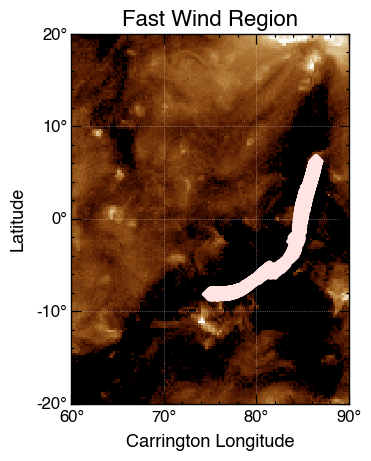

In [15]:
### FAST WIND!!!!
fast = np.logical_and(pfss.sslon >= fsw[0], pfss.sslon <=fsw[1])
ii=10
### SUBMAP CREATION
hmi_map = map_seq[1]
shape = (720, 1440)
carr_header = make_heliographic_header(hmi_map.date, hmi_map.observer_coordinate, shape, frame='carrington')
outmap = hmi_map.reproject_to(carr_header)
bottom_left = SkyCoord(60*u.degree, -20*u.degree, frame=outmap.coordinate_frame)
fsw_submap = outmap.submap(bottom_left, width=30*u.degree, height=40*u.degree)
fig = plt.figure()
ax = fig.add_subplot(projection=fsw_submap)

### FIGURE
lognorm = mpl.colors.LogNorm(vmin=np.nanpercentile(fsw_submap.data.flatten(),30), 
                        vmax=np.nanpercentile(fsw_submap.data.flatten(),99.9))
fsw_submap.plot(axes=ax, norm=lognorm)
coords = SkyCoord(lon=np.array(pfss.flon[fast][::ii])*u.deg, lat=np.array(pfss.flat[fast][::ii])*u.deg, frame=fsw_submap.coordinate_frame)
pixel_coords_x, pixel_coords_y = coords.to_pixel(fsw_submap.wcs)
ax.scatter(pixel_coords_x, pixel_coords_y, marker='D', zorder=3, facecolor='none', edgecolor=fcol, linewidth=2)
ax.set_title('Fast Wind Region')

#### FSW 2

In [16]:
### FIND TIME WHEN PLASMA LEFT SURFACE
use = np.logical_and(parker.sslon >= 125, parker.sslon <= 160)
times = parker.Time[use]
vels = parker.vr[use] * u.km/u.s
rads = (np.array(parker.rAU[use]) * u.au).to(u.km)

deltaT = np.array(rads / vels)
Tsun = [timestamp - datetime.timedelta(seconds=seconds) for timestamp, seconds in zip(times, deltaT)]

fsw_times = pd.DataFrame(data={'Tparker': times, 'Tsun':Tsun, 'sslon': parker.sslon[use], 'vr': vels})
fsw_times

,Tparker,Tsun,sslon,vr
Time,,,,
2022-02-25 16:29:11.761003,2022-02-25 16:29:11.761003,2022-02-25 09:19:44.195110,125.103125,358.76443
2022-02-25 16:29:13.508624,2022-02-25 16:29:13.508624,2022-02-25 09:13:45.855847,125.111755,353.82028
2022-02-25 16:29:15.256304,2022-02-25 16:29:15.256304,2022-02-25 09:25:01.848655,125.035710,363.19305
2022-02-25 16:29:17.003924,2022-02-25 16:29:17.003924,2022-02-25 09:29:45.816183,125.001683,367.26547
2022-02-25 16:29:18.751545,2022-02-25 16:29:18.751545,2022-02-25 09:28:47.267663,125.052855,366.38810
...,...,...,...,...
2022-02-26 05:43:02.565877,2022-02-26 05:43:02.565877,2022-02-26 00:14:04.233418,159.665222,545.26000
2022-02-26 05:43:30.527962,2022-02-26 05:43:30.527962,2022-02-25 23:37:36.093597,159.976652,490.28983
2022-02-26 05:45:18.881322,2022-02-26 05:45:18.881322,2022-02-25 23:55:01.029010,159.863713,512.41690


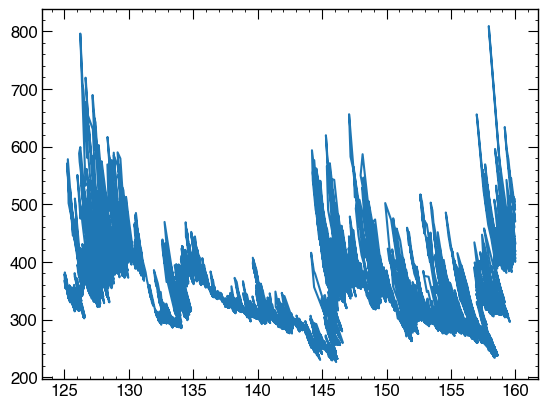

In [17]:
plt.plot(fsw_times.sslon, fsw_times.vr)

In [18]:
# data parameters
cadence = a.Sample(4*u.hour)  # querying cadence
start_date = '2022-02-21T12:00:00'  # start date of query
end_date = '2022-02-22T12:00:00'  # end date of query

hmi_result = Fido.search(a.Time(start_date, end_date),
                     a.Instrument.aia, a.Wavelength(193 * u.angstrom), cadence)
file_download = Fido.fetch(hmi_result)
map_seq2 = sunpy.map.Map(sorted(file_download))
len(map_seq2)

Files Downloaded:   0%|          | 0/6 [00:00<?, ?file/s]

6

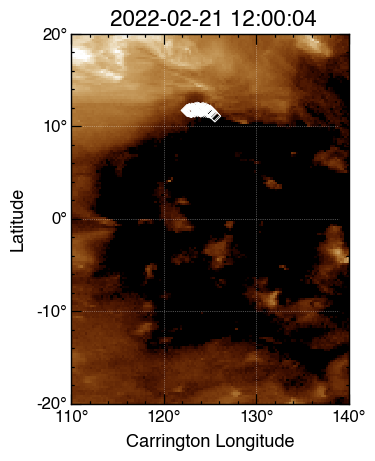

In [21]:
### FAST WIND!!!!
xx, yy = 125, 140
fast = np.logical_and(pfss.sslon >= xx, pfss.sslon <= yy)
ii=100
### SUBMAP CREATION
hmi_map = map_seq2[0]
shape = (720, 1440)
carr_header = make_heliographic_header(hmi_map.date, hmi_map.observer_coordinate, shape, frame='carrington')
outmap = hmi_map.reproject_to(carr_header)
bottom_left = SkyCoord(110*u.degree, -20*u.degree, frame=outmap.coordinate_frame)
fsw2_submap = outmap.submap(bottom_left, width=30*u.degree, height=40*u.degree)
fig = plt.figure()
ax = fig.add_subplot(projection=fsw2_submap)

### FIGURE
lognorm = mpl.colors.LogNorm(vmin=np.nanpercentile(fsw2_submap.data.flatten(),40), 
                        vmax=np.nanpercentile(fsw2_submap.data.flatten(),99.9))
fsw2_submap.plot(axes=ax, norm=lognorm)
coords = SkyCoord(lon=np.array(pfss.flon[fast][::ii])*u.deg, lat=np.array(pfss.flat[fast][::ii])*u.deg, frame=fsw2_submap.coordinate_frame)
pixel_coords_x, pixel_coords_y = coords.to_pixel(fsw2_submap.wcs)
fast = np.logical_and(parker.sslon >=xx, parker.sslon <= yy)
ax.scatter(pixel_coords_x, pixel_coords_y, marker='D', zorder=3, facecolor='None', edgecolor='white', linewidth=0.5)
# ax.set_title('Fast Wind Region')
# plt.colorbar(im)

#### try w eui

In [ ]:
### LIST OUT AVAILABLE EUI/FSI IMAGES
import sunpy_soar

start_date = '2022-02-24T12:00:00'  # start date of query
end_date = '2022-02-28T12:00:00'  #
res_eui = Fido.search(a.Time(start_date, end_date), 
                  a.Instrument("EUI"), 
                  a.Provider.soar, a.Level(2), a.soar.Product('eui-fsi174-image'))
res_eui

### DOWNLOAD EUI/FSI IMAGES
files = Fido.fetch(res_eui[::200], path="./data/eui")
files

In [ ]:
### CREATE SUNPY MAP
m_fsi = sunpy.Map(files)

### CUT FSI IMAGE
bottom_left = SkyCoord(100*u.degree, -20*u.degree, frame=outmap.coordinate_frame)
fsw2_submap = outmap.submap(bottom_left, width=40*u.degree, height=40*u.degree)

### PLOT MAP
fsw2_submap.plot()
coords = SkyCoord(lon=np.array(pfss.flon[fast][::ii])*u.deg, lat=np.array(pfss.flat[fast][::ii])*u.deg, frame=fsw2_submap.coordinate_frame)
pixel_coords_x, pixel_coords_y = coords.to_pixel(fsw2_submap.wcs)
ax.scatter(pixel_coords_x, pixel_coords_y, marker='D', zorder=3, facecolor='none', edgecolor=fcol, linewidth=2)
# ax.set_title('Fast Wind Region')

#### SLOW ALFVENIC WIND

In [22]:
### FIND TIME WHEN PLASMA LEFT SURFACE
use = np.logical_and(parker.sslon >= sasw[0], parker.sslon <=sasw[1])
times = parker.Time[use]
vels = parker.vr[use] * u.km/u.s
rads = (np.array(parker.rAU[use]) * u.au).to(u.km)

deltaT = np.array(rads / vels)
Tsun = [timestamp - datetime.timedelta(seconds=seconds) for timestamp, seconds in zip(times, deltaT)]

salf_times = pd.DataFrame(data={'Tparker': times, 'Tsun':Tsun, 'vr': vels})
salf_times

,Tparker,Tsun,vr
Time,,,
2022-02-26 09:30:35.080939,2022-02-26 09:30:35.080939,2022-02-25 12:55:27.048496,155.95187
2022-02-26 09:30:38.576240,2022-02-26 09:30:38.576240,2022-02-25 12:54:05.430572,155.77588
2022-02-26 09:31:06.538345,2022-02-26 09:31:06.538345,2022-02-25 12:55:06.766136,155.86932
2022-02-26 10:26:51.508877,2022-02-26 10:26:51.508877,2022-02-25 16:49:09.158900,185.44649
2022-02-26 10:27:05.489960,2022-02-26 10:27:05.489960,2022-02-25 16:49:48.105664,185.53345
...,...,...,...
2022-02-26 20:02:31.724186,2022-02-26 20:02:31.724186,2022-02-26 08:12:53.988469,332.27120
2022-02-26 20:02:35.219427,2022-02-26 20:02:35.219427,2022-02-26 08:16:25.923467,333.91183
2022-02-26 20:02:38.714727,2022-02-26 20:02:38.714727,2022-02-26 07:57:49.310467,325.31747


In [23]:
# data parameters
cadence = a.Sample(6*u.hour)  # querying cadence
start_date = '2022-02-25T12:00:00'  # start date of query
end_date = '2022-02-26T01:00:00'  # end date of query

hmi_result = Fido.search(a.Time(start_date, end_date),
                     a.Instrument.aia, a.Wavelength(193 * u.angstrom), cadence)
file_download = Fido.fetch(hmi_result)
map_seq = sunpy.map.Map(sorted(file_download))

Files Downloaded:   0%|          | 0/3 [00:00<?, ?file/s]

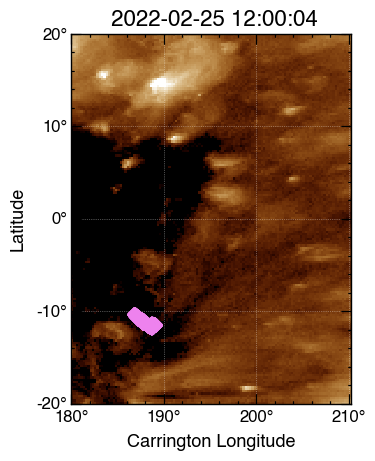

In [30]:
### SLOW ALFVENIC WIND!!!!
salf = np.logical_and(pfss.sslon >= sasw[0], pfss.sslon <=sasw[1])
### MAP CREATION
hmi_map = map_seq[0]
shape = (720, 1440)
carr_header = make_heliographic_header(hmi_map.date, hmi_map.observer_coordinate, shape, frame='carrington')
outmap = hmi_map.reproject_to(carr_header)
### CREATE SUBMAP
bottom_left = SkyCoord(180.01*u.degree, -20*u.degree, frame=outmap.coordinate_frame)
sasw_submap = outmap.submap(bottom_left, width=30*u.degree, height=40*u.degree)
bottom_left = SkyCoord(170*u.degree, -20*u.degree, frame=outmap.coordinate_frame)
sasw_submap2 = outmap.submap(bottom_left, width=9.9*u.degree, height=40*u.degree)
fig = plt.figure()
ax = fig.add_subplot(projection=sasw_submap)

### PLOT FIGURE
lognorm = mpl.colors.LogNorm(vmin=np.nanpercentile(sasw_submap.data.flatten(),20), 
                        vmax=np.nanpercentile(sasw_submap.data.flatten(),99.9))
sasw_submap.plot(axes=ax, norm=lognorm)
# sasw_submap2.plot(axes=ax, norm=lognorm)
coords = SkyCoord(lon=np.array(pfss.flon[salf])*u.deg, lat=np.array(pfss.flat[salf])*u.deg, frame=sasw_submap.coordinate_frame)
pixel_coords_x, pixel_coords_y = coords.to_pixel(sasw_submap.wcs)
ax.scatter(pixel_coords_x, pixel_coords_y, marker='D', zorder=3, facecolor='none', edgecolor=sacol, linewidth=2)

# ax.set_title('Slow Alfvenic Wind Region')

# Individual Wind Stream

2024-04-04 11:57:51 - matplotlib.backends.backend_ps - WARNING: The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2024-04-04 11:57:51 - matplotlib.backends.backend_ps - WARNING: The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


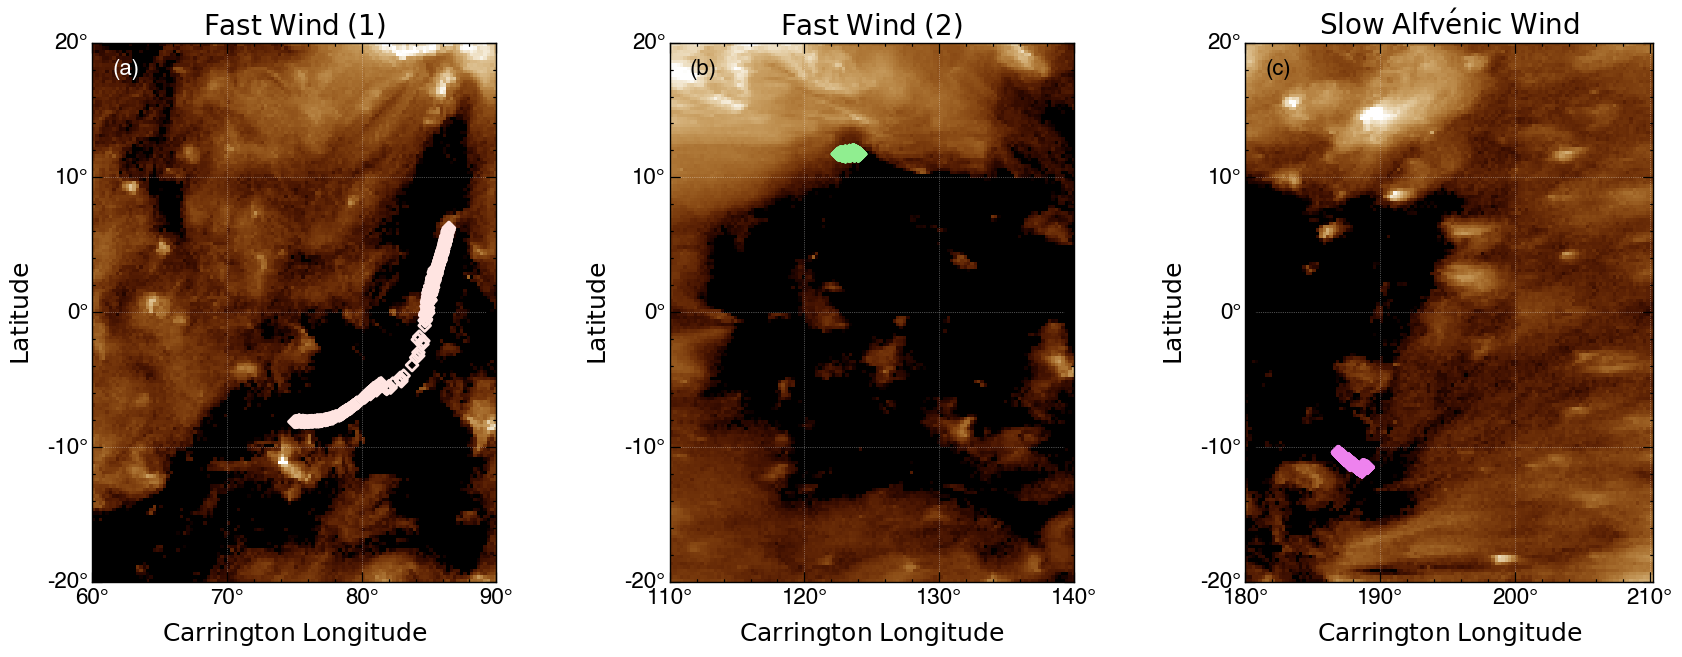

In [35]:
### SETUP FIGURE
fig = plt.figure(figsize=(22, 7))
fig.tight_layout()
grid = plt.GridSpec(1, 3, hspace=0.1, wspace=0.05) #, width_ratios=[2, 2, 1.2]) #height_ratios=[1, 1, 3], 
nf = 16
pdatetimes = parker.Time

### CREATE SUBPLOTS
ax1 = fig.add_subplot(grid[0, 0], projection=fsw_submap)
axf2 = fig.add_subplot(grid[0, 1], projection=fsw2_submap)
ax2 = fig.add_subplot(grid[0, 2], projection=sasw_submap)
# ax3 = fig.add_subplot(grid[1, 0],  projection='polar')
# ax4 = fig.add_subplot(grid[1, 1], projection='polar')
# ax5 = fig.add_subplot(grid[2, :])
axs = [ax1, axf2, ax2] #, ax3, ax4]

### REGION IDENTIFICATION
lon_footpoints = pfss.sslon
fast = np.logical_and(lon_footpoints >= fsw[0], lon_footpoints <=fsw[1])
fast2 = np.logical_and(lon_footpoints >= fsw2[0], lon_footpoints <=fsw2[1])
salf = np.logical_and(lon_footpoints >= sasw[0], lon_footpoints <=sasw[1])
hhcs = np.logical_and(lon_footpoints >= loc_hcs[0], lon_footpoints <=loc_hcs[1])
# slow = np.logical_and(lon_footpoints >=ssw[0], lon_footpoints <=ssw[1])

##### ---------- PANEL (A): FAST WIND REGION  ---------- ######
ax = ax1
### IDENTIFY FOOTPOINTS
lon_footpoints = pfss.sslon
fast = np.logical_and(lon_footpoints >= fsw[0], lon_footpoints <=fsw[1])

### PLOT AIA IMAGE
lognorm = mpl.colors.LogNorm(vmin=np.nanpercentile(fsw_submap.data.flatten(),30), 
                        vmax=np.nanpercentile(fsw_submap.data.flatten(),99.9))
fsw_submap.plot(axes=ax, norm=lognorm)

### PLOT FOOTPOINTS
coords = SkyCoord(lon=np.array(pfss.flon[fast][::50])*u.deg, lat=np.array(pfss.flat[fast][::50])*u.deg, frame=fsw_submap.coordinate_frame)
pixel_coords_x, pixel_coords_y = coords.to_pixel(fsw_submap.wcs)
ax.scatter(pixel_coords_x, pixel_coords_y, marker='D', zorder=3, facecolor='none', edgecolor=fcol, linewidth=2)
### PLOT TITLE
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel(r'$\rm Carrington \; Longitude$', fontsize=18)
ax.set_ylabel(r'$\rm Latitude$', fontsize=18)
ax.set_title(r'$\rm Fast \; Wind \; (1)$', fontsize=20)

##### ---------- PANEL (B): FAST WIND (2) REGION  ---------- ######
ax = axf2
### IDENTIFY FOOTPOINTS
lon_footpoints = pfss.sslon
fast = np.logical_and(lon_footpoints >= fsw2[0], lon_footpoints <=fsw2[1])

### PLOT AIA IMAGE
lognorm = mpl.colors.LogNorm(vmin=np.nanpercentile(fsw2_submap.data.flatten(),40), 
                        vmax=np.nanpercentile(fsw2_submap.data.flatten(),99.9))
fsw2_submap.plot(axes=ax, norm=lognorm)

### PLOT FOOTPOINTS
coords = SkyCoord(lon=np.array(pfss.flon[fast2][::10])*u.deg, lat=np.array(pfss.flat[fast2][::10])*u.deg, frame=fsw2_submap.coordinate_frame)
pixel_coords_x, pixel_coords_y = coords.to_pixel(fsw2_submap.wcs)
ax.scatter(pixel_coords_x, pixel_coords_y, marker='D', zorder=3, facecolor='none', edgecolor=f2col, linewidth=2)

### PLOT TITLE
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel(r'$\rm Carrington \; Longitude$', fontsize=18)
ax.set_ylabel(r'$\rm Latitude$', fontsize=18)
ax.set_title(r'$\rm Fast \; Wind \; (2)$', fontsize=20)

##### ---------- PANEL (C): SLOW ALFVENIC WIND  ---------- ######
ax = ax2
### IDENTIFY FOOTPOINTS
lon_footpoints = pfss.sslon
salf = np.logical_and(lon_footpoints >= sasw[0], lon_footpoints <=sasw[1])

### PLOT AIA IMAGE
lognorm = mpl.colors.LogNorm(vmin=np.nanpercentile(sasw_submap.data.flatten(),20), 
                        vmax=np.nanpercentile(sasw_submap.data.flatten(),99.9))
sasw_submap.plot(axes=ax, norm=lognorm)

### PLOT FOOTPOINTS
coords = SkyCoord(lon=np.array(pfss.flon[salf][::10])*u.deg, lat=np.array(pfss.flat[salf][::10])*u.deg, frame=sasw_submap.coordinate_frame)
pixel_coords_x, pixel_coords_y = coords.to_pixel(sasw_submap.wcs)
ax.scatter(pixel_coords_x, pixel_coords_y, marker='D', zorder=3, facecolor='none', edgecolor=sacol, linewidth=2)

### TITLE 
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel(r'$\rm Carrington \; Longitude$', fontsize=18)
ax.set_ylabel(r'$\rm Latitude$', fontsize=18)
ax.set_title(r'$\rm Slow \; Alfv\'enic \; Wind$', fontsize=20)

##### ---------- PANEL LABELS  ---------- ######
ax1.text(0.05, 0.97, '(a)', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='left', color='white')
axf2.text(0.05, 0.97, '(b)', transform=axf2.transAxes, fontsize=16, fontweight='bold', va='top', ha='left', color='k')
ax2.text(0.05, 0.97, '(c)', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top', ha='left', color='black')
# ax4.text(0.05, 0.97, '(d)', transform=ax4.transAxes, fontsize=16, fontweight='bold', va='top', ha='left', color='black')

### SAVE FIGURE
fig.savefig('figures/fig5.png', bbox_inches='tight') #PNG
fig.savefig('eps_figures/fig5.eps', bbox_inches='tight') #PDF

# Figure 6: Full Magnetic Field Model

In [ ]:
fsw3 = [130, 140]
### SETUP FIGURE
fig = plt.figure(figsize=(18, 12))
fig.tight_layout()
grid = plt.GridSpec(3, 1, height_ratios=[3, 1, 1], hspace=0) #height_ratios=[1, 1, 3], 
nf = 16
pdatetimes = parker.Time

### CREATE SUBPLOTS
ax1 = fig.add_subplot(grid[0, :])
ax2 = fig.add_subplot(grid[1, :])
ax3 = fig.add_subplot(grid[2, :])
nf = 16
pdatetimes = parker.Time

##### ---------- PANEL (A): PFSS FIGURE  ---------- ######
ax = ax1
### READ IN EUV MAP
synoptic = 'E11_14days.fits'
smap = sunpy.map.Map(synoptic)

### PLOT PFSS MODEL
plot_pfss(smap, hcs, psp_at_source_surface, flines_psp, pdatetimes, ax=ax, nf=20, dim=[0, 240, -90, 90])
ax.set_xticklabels([])
ax.tick_params(axis='both', which='major', labelsize=16) 
ax.set_ylabel(r'$\rm Carrington \; Latitude \; [deg]$', fontsize=18)

### FSW RECTANGLE
rect = mpl.patches.Rectangle((60, -20), 40, 40, linewidth=5, edgecolor=fcol, facecolor='none')
ax.add_patch(rect) 
ax.text(60, -25, 'Fig. 7: Panel (a)', fontsize=20, fontweight='bold', va='top', ha='left', color='white')

### FSW2 RECTANGLE
rect = mpl.patches.Rectangle((110, -20), 30, 40, linewidth=5, edgecolor=f2col, facecolor='none')
ax.add_patch(rect) 
ax1.text(110, 32, 'Fig. 7: Panel (b)', fontsize=20, fontweight='bold', va='top', ha='left', color='white')
ax1.sharex(ax3)

### SASW RECTANGLE
rect = mpl.patches.Rectangle((180, -20), 30, 40, linewidth=5, edgecolor=sacol, facecolor='none')
ax.add_patch(rect) 
ax1.text(180, 32, 'Fig. 7: Panel (c)', fontsize=20, fontweight='bold', va='top', ha='left', color='k')
ax1.sharex(ax3)

### LONGITUDE AND LATITUDE SLICE
# ax1.axhline(-3.15, color='tomato', lw=3, linestyle='dashed', zorder=10)
# ax1.axvline(180, color='gold', lw=3, linestyle='dashed', zorder=10)

##### ---------- FOOTPOINT FIELD STRENGTH ---------- ######
axf = ax2
ss=40
nf=32

### REGIONS
lon_footpoints = pfss.sslon[::nf]
fast = np.logical_and(lon_footpoints >= fsw[0], lon_footpoints <=fsw[1])
salf = np.logical_and(lon_footpoints >= sasw[0], lon_footpoints <=sasw[1])
hhcs = np.logical_and(lon_footpoints >= loc_hcs[0], lon_footpoints <=loc_hcs[1])
fast2 = np.logical_and(lon_footpoints >=fsw2[0], lon_footpoints <=fsw2[1])

### DATA
d1 = pfss.flon[::nf]
d2 = np.abs(B0[::nf]*1e5)
axf.scatter(d1, d2, c='grey', s=ss, linewidth=0.8, edgecolor='k')
axf.scatter(d1[fast], d2[fast], c=fcol, s=ss, linewidth=0.8, edgecolor='k')
axf.scatter(d1[fast2], d2[fast2], c=f2col, s=ss, linewidth=0.8, edgecolor='k')
axf.scatter(d1[salf], d2[salf], c=sacol, s=ss, linewidth=0.8, edgecolor='k')
# axf.scatter(d1[hhcs], d2[hhcs], c=hcol, s=ss, linewidth=0.8, edgecolor='k')

### LABELS 
axf.set(ylim=(-12.5, 112.5), yticks=np.arange(0, 101, step=25))
axf.set_ylabel(r'$\rm |B_0| \;  [G]$', fontsize=18)
axf.axhline(1, color='k', linestyle='dashed', zorder=-1)
axf.tick_params(axis='both', which='major', labelsize=16) 
axf.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
axf.set_xticklabels([])
axf.sharex(ax3)

##### ---------- EXPANSION FACTOR  ---------- ######
axf = ax3
nf=32
lon_footpoints = pfss.sslon[::nf]
fast = np.logical_and(lon_footpoints >= fsw[0], lon_footpoints <=fsw[1])
salf = np.logical_and(lon_footpoints >= sasw[0], lon_footpoints <=sasw[1])
hhcs = np.logical_and(lon_footpoints >= loc_hcs[0], lon_footpoints <=loc_hcs[1])
fast2 = np.logical_and(lon_footpoints >=fsw2[0], lon_footpoints <=fsw2[1])

### PLOT DATA
d1 = pfss.flon[::nf]
d2 = pfss.fss[::nf]
axf.scatter(d1, d2, c='grey', s=ss, linewidth=0.8, edgecolor='k')
axf.scatter(d1[fast], d2[fast], c=fcol, s=ss, linewidth=0.8, edgecolor='k')
axf.scatter(d1[fast2], d2[fast2], c=f2col, s=ss, linewidth=0.8, edgecolor='k')
axf.scatter(d1[salf], d2[salf], c=sacol, s=ss, linewidth=0.8, edgecolor='k')

### LIMITS AND LABELS
# axf.set(ylim=(-, 125), yticks=np.arange(-100, 101, step=50))
axf.set_yscale('log')
axf.tick_params(axis='both', which='major', labelsize=16) 
axf.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
axf.set_ylabel(r'$\rm f_{ss}$', fontsize=18)
axf.set_xlabel(r'$\rm Carrington \; Longitude \; [deg]$', fontsize=18)
axf.set(xlim=(25, 225), xticks=np.arange(50, 201, step=25))

##### ---------- PANEL LABELS  ---------- ######
ax1.text(0.02, 0.93, '(a)', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='left', color='black')
ax2.text(0.02, 0.93, '(b)', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top', ha='left', color='black')
ax3.text(0.02, 0.93, '(c)', transform=ax3.transAxes, fontsize=16, fontweight='bold', va='top', ha='left', color='black')

### SAVE FIGURE
fig.savefig('eps_figures/fig6.eps', bbox_inches='tight') #EPS
fig.savefig('eps_figures/fig6.pdf', bbox_inches='tight') #EPS
fig.savefig('figures/fig6.png', bbox_inches='tight') #EPS
print('figure saved')

plt.show()